In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [4]:
path = "Brent_crude_oil.csv"
brent_df=pd.read_csv(path)

In [5]:
brent_df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/01/2010,80.120003,79.82,80.120003,80.120003,80.120003,97.0


In [6]:
brent_df.dropna(inplace = True)

In [7]:
brent_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
df1=brent_df.copy()

In [11]:
df1["Date"]=pd.to_datetime(brent_df["Date"],format='%d/%m/%Y')
df1.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,80.120003,79.82,80.120003,80.120003,80.120003,97.0


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2485 entries, 0 to 3066
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2485 non-null   datetime64[ns]
 1   Open       2485 non-null   float64       
 2   High       2485 non-null   float64       
 3   Low        2485 non-null   float64       
 4   Close      2485 non-null   float64       
 5   Adj Close  2485 non-null   float64       
 6   Volume     2485 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 155.3 KB


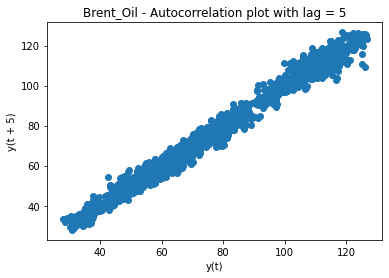

In [13]:
plt.figure()
lag_plot(df1['Close'], lag=5)
plt.title('Brent_Oil - Autocorrelation plot with lag = 5')
plt.show()

We can now confirm that ARIMA is going to be a good model to be applied to this type of data (there is auto-correlation in the data).
Finally, let’s plot the stock price evolution over time.

In [14]:
# df1

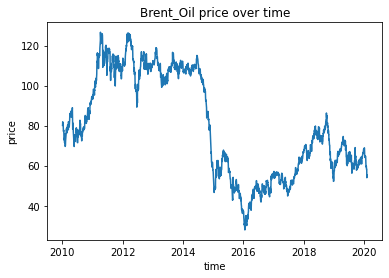

In [15]:
plt.plot(df1["Date"], df1["Close"])
# plt.xticks(np.arange(0,2485,100), df1['Date'][0:2485:100])
plt.title("Brent_Oil price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

Next, let’s divide the data into a training (80 % ) and test (20%) set. For this tutorial we select the following ARIMA parameters: p=4, d=1 and q=0.

In [16]:
train_data, test_data = df1[0:int(len(df1)*0.8)], df1[int(len(df1)*0.8):]

In [17]:
training_data = train_data['Close'].values
test_data = test_data['Close'].values

history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    #yhat = output[0][0]
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

  
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 1.635729898059501


In [18]:
from statsmodels.tsa.stattools import adfuller

In [27]:
series=df1['Close']
series

0       80.120003
1       80.589996
2       81.889999
3       81.510002
4       81.370003
          ...    
3061    58.290001
3062    58.160000
3064    58.200001
3065    53.959999
3066    55.279999
Name: Close, Length: 2485, dtype: float64

In [30]:

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 12, cutoff = 0.01):
#Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        pvalue = dftest[1]
        if pvalue < cutoff:
          print('p-value = %.4f. The series is likely stationary.' % pvalue)
        else:
          print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)

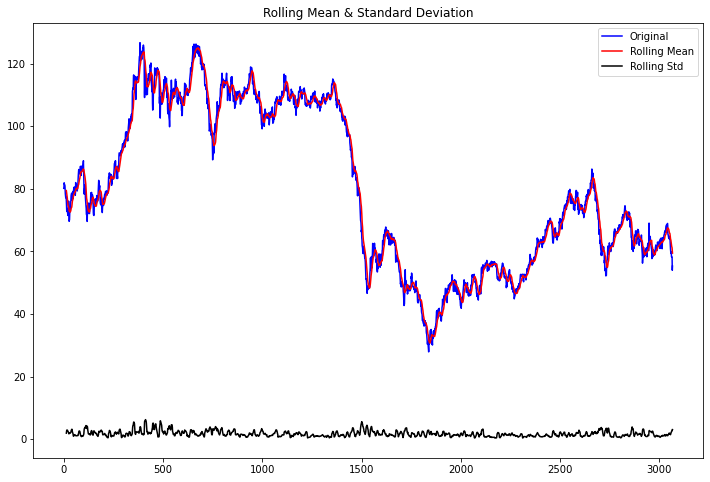

Results of Dickey-Fuller Test:
p-value = 0.7296. The series is likely non-stationary.
p-value = 0.7296. The series is likely non-stationary.
p-value = 0.7296. The series is likely non-stationary.
Test Statistic                   -1.062977
p-value                           0.729608
#Lags Used                        2.000000
Number of Observations Used    2482.000000
Critical Value (1%)              -3.432987
Critical Value (5%)              -2.862705
Critical Value (10%)             -2.567390
dtype: float64


In [31]:
test_stationarity(series)

In [14]:
# rowloc = df1.loc[df1["Close"] == 67.620003].index[1]
# rowloc

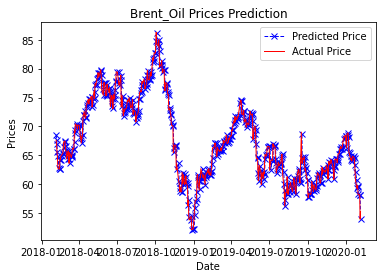

In [15]:
test_set_range = df1[int(len(df1)*0.8):].Date
plt.plot(test_set_range, model_predictions, color='blue', marker='x', linestyle='dashed',label='Predicted Price', lw=1)
plt.plot(test_set_range, test_data, color='red', label='Actual Price', lw=1)
plt.title('Brent_Oil Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df1.Date[881:1259:50])
plt.legend()
plt.show()

In [16]:
date_df=pd.DataFrame(df1[int(len(df1)*0.8):].Date)
df_test = pd.DataFrame(data=test_data)
df_preds = pd.DataFrame(data=model_predictions)

display(date_df.head(3), df_test.head(3), df_preds.head(3))

,Date
2459,2018-02-05
2460,2018-02-06
2461,2018-02-07


,0
0,67.620003
1,66.860001
2,65.510002


,0
0,68.575802
1,67.661133
2,66.906992


In [17]:
date_df.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_preds.reset_index(drop=True, inplace=True)

df_preds = df_preds.shift(periods=-1)

# p = p.iloc[:-1]
# t = t.iloc[:-1]

frames=[date_df['Date'],df_test[0],df_preds[0]]
headers=['Date','test','preds']
graphdata= pd.concat(frames, axis=1, keys=headers)

# graphdata = df_test.merge(df_preds, how='inner', suffixes=('_actual', '_prediction'))
graphdata

,Date,test,preds
0,2018-02-05,67.620003,67.661133
1,2018-02-06,66.860001,66.906992
2,2018-02-07,65.510002,65.550934
3,2018-02-08,64.809998,64.832978
4,2018-02-09,62.790001,62.836886
...,...,...,...
492,2020-01-30,58.290001,58.290388
493,2020-01-31,58.160000,58.212609
494,2020-02-03,58.200001,58.196170
495,2020-02-04,53.959999,54.069513


In [46]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure([

    go.Scatter(
        name='Actual',
        x=graphdata.Date,
        y=graphdata['test'],
        mode='lines',
        marker=dict(color="#008080"),
        line=dict(width=1),
        showlegend=True
    ),
    go.Scatter(
        name='Prediction',
        x=graphdata.Date,
        y=graphdata['preds'],
        marker=dict(color="#FF8C00"),
        line=dict(width=1),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        showlegend=True
    )
])

fig.update_layout(
    yaxis_title='',
    title='',
    hovermode="x"
)

fig.show()